# Paint by Numbers Generator with Style Adaption (Neural Style Transfer)

In [1]:
import utils.utils_nst as utils_nst
import utils.utils as utils
import torch
import os
import platform
import matplotlib.pyplot as plt
import cv2

In [2]:
# check for gpu otherwise use cpu
if platform.system() == "Darwin":  # checking if it's macOS
    if torch.backends.mps.is_available():
        device = torch.device("mps")
elif torch.cuda.is_available():  # if not macOS, check for CUDA availability
    device = torch.device("cuda")
else:  # if neither macOS nor CUDA, default to CPU
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


---------------

## Style Adaption (Neural Style Transfer)
### (skip to the next section if not using)

#### User Inputs:

In [3]:
content_img_name = "scenery.jpg"
style_img_name = "impression_monet.png"

# These weights vary the intensity of the adaption 
# To understand their effect refer to: https://github.com/gordicaleksa/pytorch-neural-style-transfer/tree/master)
style_weight = 3e4          # vary (1e1, 1e2, 1e3, 1e4), default: 3e4
tv_weight = 1e2             # vary (1e1, 1e4, 1e5, 1e6), defaukt: 1e0

In [ ]:
# constants
content_weight = 1e5   
max_size = 400     

data_directory = os.path.join(os.getcwd(), 'data')
content_image, style_image = utils_nst.image_loading(data_directory, content_img_name, style_img_name, max_size)

# Display content image and style image
plt.figure(figsize=(15, 10))

# Content image
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

# Style image
plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

plt.show()


In [ ]:
optimization_config = dict()
optimization_config['content_weight'] = content_weight 
optimization_config['style_weight'] = style_weight
optimization_config['tv_weight'] = tv_weight

# Preprocess the content and style images
content_tensor = utils_nst.preprocess_image(content_image, device)
style_tensor = utils_nst.preprocess_image(style_image, device)

# run style adaption training
merged_image = utils_nst.neural_style_transfer(optimization_config, content_tensor, style_tensor, device)

In [ ]:
# Convert and display the adaption image

image = utils_nst.visualise_final_image(merged_image)


# Display content image and style image
plt.figure(figsize=(15, 10))

# Content image
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

# Style image
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Image with Style Adaption')
plt.axis('off')

plt.show()

-----------

## Paint by Number Generation

#### User Inputs:
(Note: Ensure image is placed in data/content_images)

In [3]:
image_name = 'scenery.jpg'    # Set to image_name=None if Style Adaption was previosuly used

# These vary the quantization of the image, vary these to change the complexity of the image
# Increasing compactness --> image looking more square-like
# Increasing n_segments --> image becomes more advanced and complex
n_segments = 3000       # maximum: 5000
compactness = 10        # default: 10

# This varies the number of colours in final colour palette, use no more than 30
n_colors = 30

In [4]:
if image_name!=None:
    images_dir = os.path.join(os.getcwd(), 'data/content_images')
    img_path = os.path.join(images_dir, image_name)
    image = cv2.imread(img_path)

height, width, _ = image.shape
print(f"Before: Height - {height}, Width - {width}")

max_dimension = 2000
min_dimension = 1000
if height > max_dimension or width > max_dimension:
    scaling_factor = max_dimension / max(height, width)
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    image = cv2.resize(image, (new_width, new_height))
elif height < min_dimension or width < min_dimension:
    scaling_factor = min_dimension / min(height, width)
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    image = cv2.resize(image, (new_width, new_height))

if image_name!=None:
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
else:
    base_content_name = os.path.splitext(content_img_name)[0]
    base_style_name = os.path.splitext(style_img_name)[0]
    image_name = f"{base_content_name}_{base_style_name}"


# # Resize the image
height, width, _ = image.shape
print(f"After: Height - {height}, Width - {width}")

Before: Height - 1467, Width - 2201
scenery.jpg
After: Height - 1333, Width - 2000


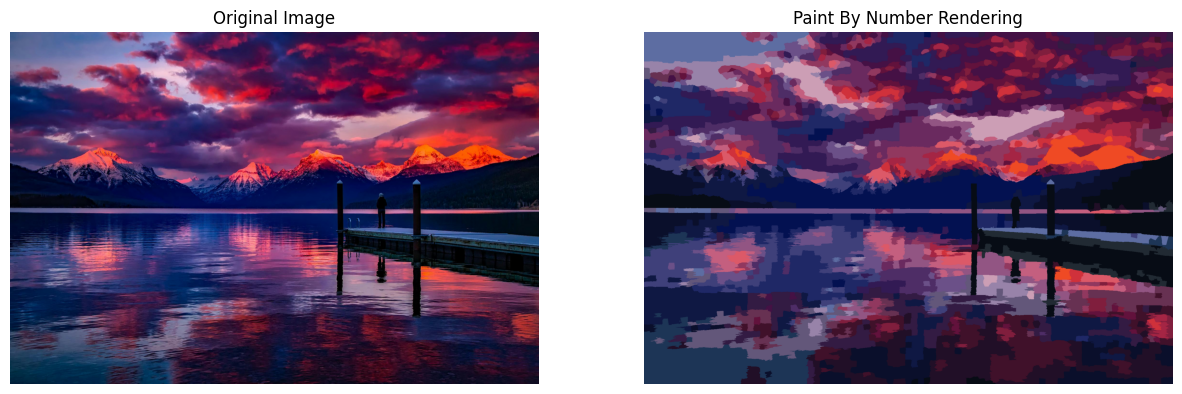

In [5]:
# Quantise image

# Apply SLIC superpixel segmentation
segments = utils.slic_superpixel_segmentation(image, n_segments=n_segments, compactness=compactness)

# Quantize superpixels to a limited color palette
quantized_image, quantized_indices, quantized_colors = utils.quantize_superpixels(image, segments, n_colors=n_colors)

# Display the original and quantized images side by side
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Quantized image
plt.subplot(1, 2, 2)
plt.imshow(quantized_image)
plt.title('Paint By Number Rendering')
plt.axis('off')

plt.show()

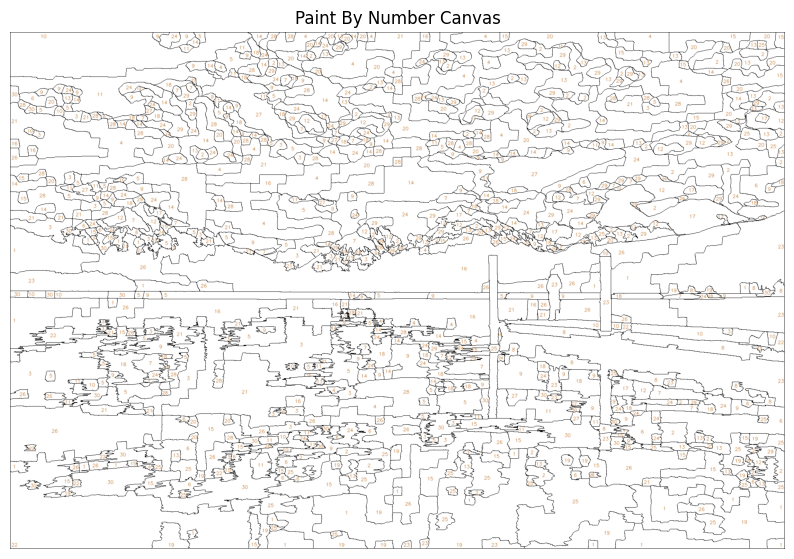

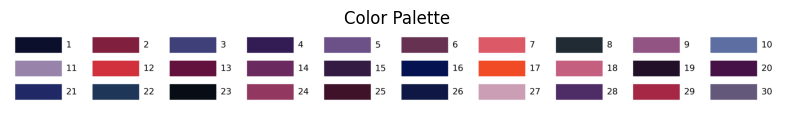

In [6]:
### Create black and white image with numbers and colour palette

# Create edges and labeled image
edges = utils.create_paint_by_number_edges(quantized_indices)
labeled_image_on_white = utils.label_regions_within_edges(quantized_indices, edges)

# Add a black border around 'labeled_image_on_white'
labeled_image_on_white_with_border = utils.add_black_border(labeled_image_on_white, border_size=1)

# Display the color palette
palette_image = utils.display_color_palette(quantized_colors, colors_per_row=10)

# save images
utils.save_images(image_name, image, quantized_image, labeled_image_on_white_with_border, palette_image)


# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(labeled_image_on_white_with_border)
plt.title('Paint By Number Canvas')
plt.axis('off')
plt.show()


# Display the color palette image
plt.figure(figsize=(10, 10))
plt.imshow(palette_image)  # Using the PIL image returned by display_color_palette
plt.title('Color Palette')
plt.axis('off')
plt.show()